# Ensamble de los modelos

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.models import load_model 
from sklearn.metrics import r2_score
import pickle
from sklearn import metrics
import tensorflow as tf
from numpy import hstack
from sklearn.model_selection import ParameterGrid


### lectura de datos

In [2]:
df = pd.read_csv("HistoricalQuotes.csv")
df = df.sort_values(by=['date'],ascending=True)
df = df.reset_index(drop=True)

In [43]:
precio_cierre = df["close"].values.reshape(-1,1)

In [4]:
sc = MinMaxScaler(feature_range = (0, 1))

In [5]:
precio_cierre_normalizado = sc.fit_transform(precio_cierre)

In [6]:
time_to_predict = 60

In [7]:
real_stock_price = (precio_cierre[-(time_to_predict):])

In [44]:
def graficar_modelo(real,pred,nombre):
    """
    Función para gráficar el resultado y métricas de los modelos
    """
    figure(figsize=(7,5))
    plt.plot(real, color = 'red', label = 'Real S&P Stock Price')
    plt.plot(pred, color = 'blue', label = 'Predicted S&P Stock Price')
    plt.title(nombre)
    plt.xlabel('Date'+'\n'+
              'R2: '+str(r2_score(real,pred))+'\n \n'
              'MSE: '+str(metrics.mean_squared_error(real, pred))
              )
    plt.ylabel('Close')
    plt.legend()
    return plt.show()

### Carga de datos de prueba para cada modelo

In [9]:
with open('X_test_1.data', 'rb') as filehandle:  
    x_test_1 = pickle.load(filehandle)
    
with open('X_test_2.data', 'rb') as filehandle:  
    x_test_2 = pickle.load(filehandle)
    
with open('X_test_3.data', 'rb') as filehandle:  
    x_test_3 = pickle.load(filehandle)

### Carga de los modelos 

In [10]:
rnn_univariate = load_model("rnn_univariate.h5") 
cnn_univariate = load_model("cnn_univariate.h5")
cnn_multivariate = load_model("cnn_multivariate.h5")

In [11]:
modelos = [rnn_univariate,cnn_univariate,cnn_multivariate]

sets_test = [x_test_1,x_test_2,x_test_3]

## Resumen modelos

### resultado recurrente univaridada

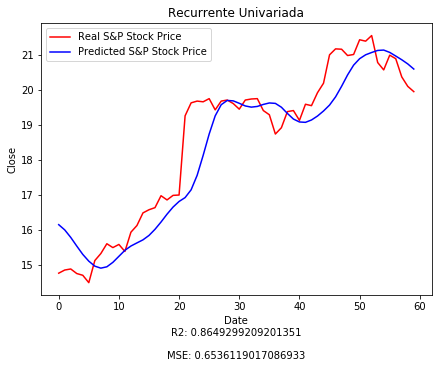

In [12]:
pred1 = sc.inverse_transform(rnn_univariate.predict(x_test_1))
graficar_modelo(real_stock_price,pred1,"Recurrente Univariada")

### Resultado convolucional univariada

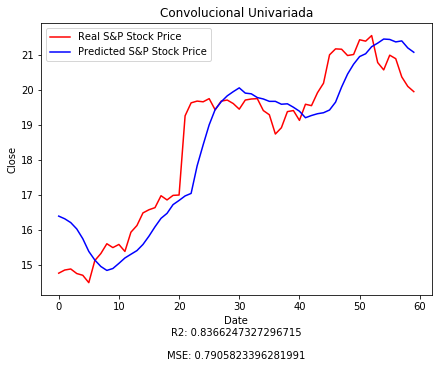

In [13]:
pred2 = sc.inverse_transform(cnn_univariate.predict(x_test_2))
graficar_modelo(real_stock_price,pred2,"Convolucional Univariada")

### Resultado Convolucional multivariada

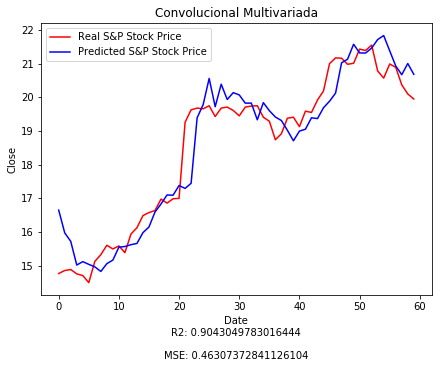

In [14]:
pred3 = sc.inverse_transform(cnn_multivariate.predict(x_test_3))
graficar_modelo(real_stock_price,pred3,"Convolucional Multivariada")

# Stacking

## Método 1 Ensambles: Promedio de modelos

En este método, cada modelo aporta exactamente lo mismo a la predicción final, este sería nuestro modelo base para comparar los otros métodos de stacking

In [15]:
valores_promedio = []
for i in range(len(x_test_1)):
    valores_promedio.append((pred1[i]+pred2[i]+pred3[i])/3)    

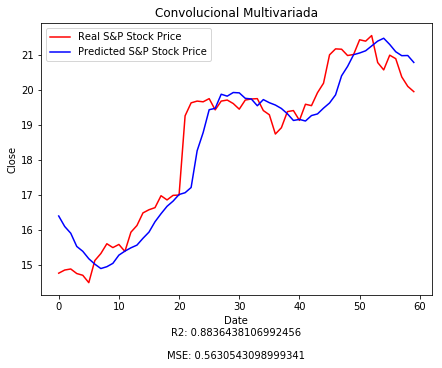

In [16]:
graficar_modelo(real_stock_price,valores_promedio,"Convolucional Multivariada")

#### Este modelo fue efectivamente superior a los modelos de RNN y CNN univariados por sí solos, pero no superior al CNN multivariada

## Método 2: TensorFlow (LR)

Se encuentra los pesos más adecuados para una predicción más cercana al valor real 

<img src="https://render.githubusercontent.com/render/math?math=%5Ctheta%20%3D%20%28%7BX%7D%5E%5Cintercal%20.%20X%29%5E-1%20.%20%7BX%7D%5E%5Cintercal%20.%20y&mode=display" width=200>

In [35]:
X_train = hstack((pred1,pred2,pred3))
y_train = real_stock_price

In [36]:
# Dimensiones de mi dataset
m = len(X_train)
n = len(X_train[0])

# entrada de datos original + vector BIAS
X_train_bias = np.c_[np.ones((m, 1)), X_train]

# como aquí voy a multiplicar TODOOOO mi dataset de una vez, lo convierto en constante, 
# no voy a estar extrayendo fragmentos de mi x_train en forma de batch
X = tf.constant(X_train_bias, dtype=tf.float32)

In [37]:
# y_train es un arreglo 1D, pero necesitamos transformarlo a un vector columna # para poder hacer la ecuación normal, 
y = tf.constant(y_train.reshape(-1, 1), dtype=tf.float32)

XT = tf.transpose(X)

# ecuación normal de regresión lineal
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [38]:
# bias a mi test set para predecir
X_test_bias = np.c_[np.ones((len(X_train), 1)), X_train]

In [39]:
# mutiplico X test por mi theta 
y_pred = np.dot(X_test_bias,theta_value)

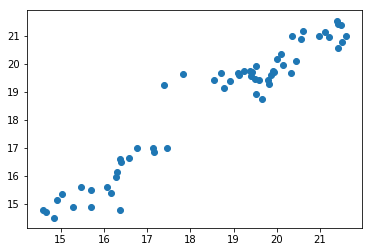

In [40]:
plt.scatter(y_pred,real_stock_price)

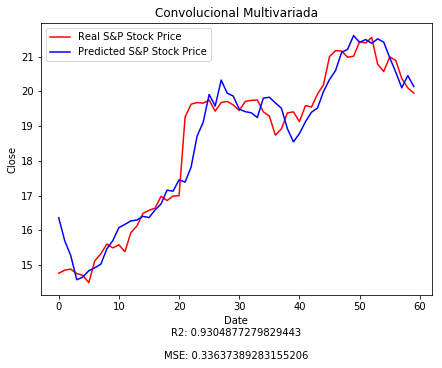

In [41]:
graficar_modelo(real_stock_price,y_pred,"Convolucional Multivariada")


### El resultado fue un R2 superior y MSE inferior a todos los modelos de forma independiente
---

* ToDo
 - Adicionar valores de otros indices, divisas o comodities
 - Transformaciones sobre la serie
 - Otros modelos (RNN multivariada) (multistep)


